In [1]:
from bertopic import BERTopic

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [3]:
model_type = "distil"
today_str = "20240315"

# DistilRoBERTa BERTopic modelling
https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html 

### Load data and run the model
1. Sentence tranformer https://huggingface.co/sentence-transformers/all-distilroberta-v1 
2. UMAP https://umap-learn.readthedocs.io/en/latest/parameters.html It doesn't have variance like PCA so it's less "interpretable", but it retains local details and is non-linear so better than PCA in those aspects
3. HDBSCAN https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#selecting-cluster-selection-epsilon 
4. Vectorization
5. Topic representation

In [4]:
# Load the dataset
df = pd.read_csv(r"../../all_side_events_complete_lang.csv", encoding='utf-8')
timestamp = df['Year'].tolist()
docs = df['Title/Description_new'].str.lower().tolist()

In [5]:
# 1. distilBERT  sentence transformer
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("all-distilroberta-v1") 
embeddings = sentence_model.encode(docs, show_progress_bar=True)
pd.DataFrame(data=embeddings).to_csv("BERT_result/"+model_type+"_embeddings.csv",index=False)
embeddings

Batches:   0%|          | 0/147 [00:00<?, ?it/s]

array([[-0.00348329, -0.02112344, -0.00033809, ..., -0.01654083,
         0.00312223,  0.02370815],
       [ 0.00937101, -0.051101  ,  0.01213924, ...,  0.02175645,
         0.012431  ,  0.04933694],
       [ 0.02139529, -0.03822016, -0.00884981, ..., -0.00774835,
         0.02124234,  0.00324309],
       ...,
       [ 0.03178161, -0.01165111, -0.04044782, ...,  0.08003067,
         0.03839185, -0.01950679],
       [ 0.03069262, -0.04655658, -0.00838885, ...,  0.02065767,
         0.0193687 ,  0.04931406],
       [ 0.03052036, -0.03028588, -0.03493284, ..., -0.00138192,
         0.01548375,  0.04785818]], dtype=float32)

In [6]:
# 2. UMAP dimension reduction 
# set random state to reduce the stochastic behaviour
from umap import UMAP # default dimension reduction
from sklearn.decomposition import PCA # alternative dimension reduction
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)
pd.DataFrame(data=reduced_embeddings).to_csv("BERT_result/"+model_type+"_embeddings_reduced.csv",index=False)
plot_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
pd.DataFrame(data=plot_embeddings).to_csv("BERT_result/"+model_type+"_embeddings_plot.csv",index=False)#

In [7]:
# 3. HDBSCAN for clustering
from hdbscan import HDBSCAN # default clustering
from sklearn.cluster import KMeans # alternative clustering
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [8]:
# 4. vectorizer
# remove stop words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

In [9]:
# Create a BERTopic instance
topic_model = BERTopic(verbose=True, umap_model=umap_model, hdbscan_model=hdbscan_model,vectorizer_model=vectorizer_model)
# Fit the model on your dataset
topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)

2024-03-16 15:20:50,384 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-16 15:21:20,533 - BERTopic - Dimensionality - Completed ✓
2024-03-16 15:21:20,546 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-16 15:21:21,223 - BERTopic - Cluster - Completed ✓
2024-03-16 15:21:21,262 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-16 15:21:23,729 - BERTopic - Representation - Completed ✓


### Save and visualize

In [10]:
# save pickle file
topic_model.save(model_type+"_"+today_str, serialization="pickle")

2024-03-16 15:21:25,350 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [11]:
# export topic result
top_topics = topic_model.get_topic_info()
top_topics.to_csv("BERT_result/"+model_type+"_result.csv",index=False)
len(top_topics)-1

63

In [12]:
# export document info
document_info = topic_model.get_document_info(docs)
document_info.to_csv("BERT_result/"+model_type+"_document_info.csv",index=False)

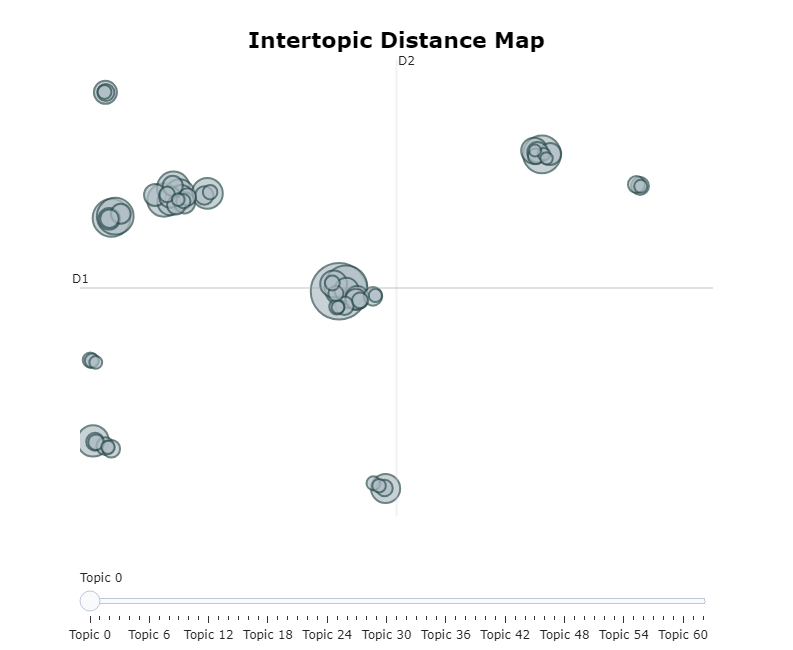

In [13]:
# plot intertopic distance  
intertopic_distance = topic_model.visualize_topics()
intertopic_distance.write_html("BERT_result/"+model_type+"_intertopic.html")
intertopic_distance

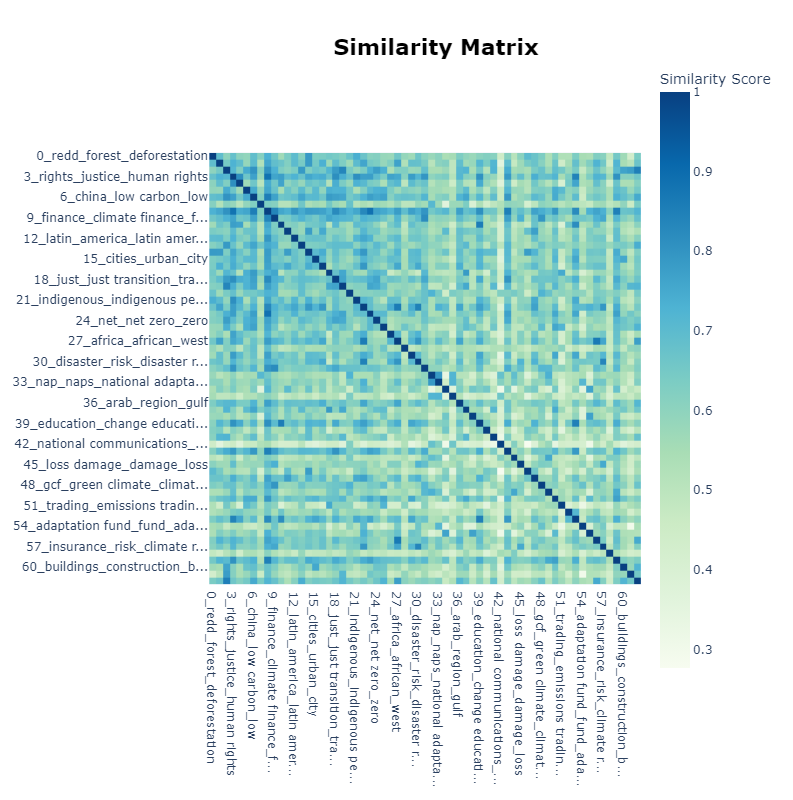

In [14]:
# plot similarity matrix
heatmap_fig = topic_model.visualize_heatmap()
heatmap_fig.write_html("BERT_result/"+model_type+"_similarity.html")
heatmap_fig

20it [00:10,  1.86it/s]


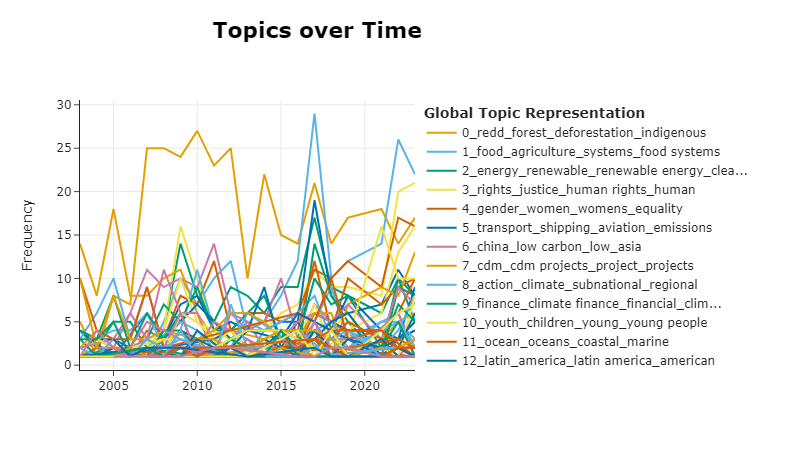

In [15]:
# plot topic result over time
topics_over_time = topic_model.topics_over_time(docs, timestamp)
topics_over_time_fig = topic_model.visualize_topics_over_time(topics_over_time)
topics_over_time_fig.write_html("BERT_result/"+model_type+"_over_time.html")
topics_over_time_fig

In [16]:
# export topic result over time
df['Topic'] = topics
topic_counts_per_year = df.groupby(['Year', 'Topic']).size().unstack(fill_value=0)
topic_counts_per_year.to_csv("BERT_result/"+model_type+"_topics_per_year.csv",index=False)

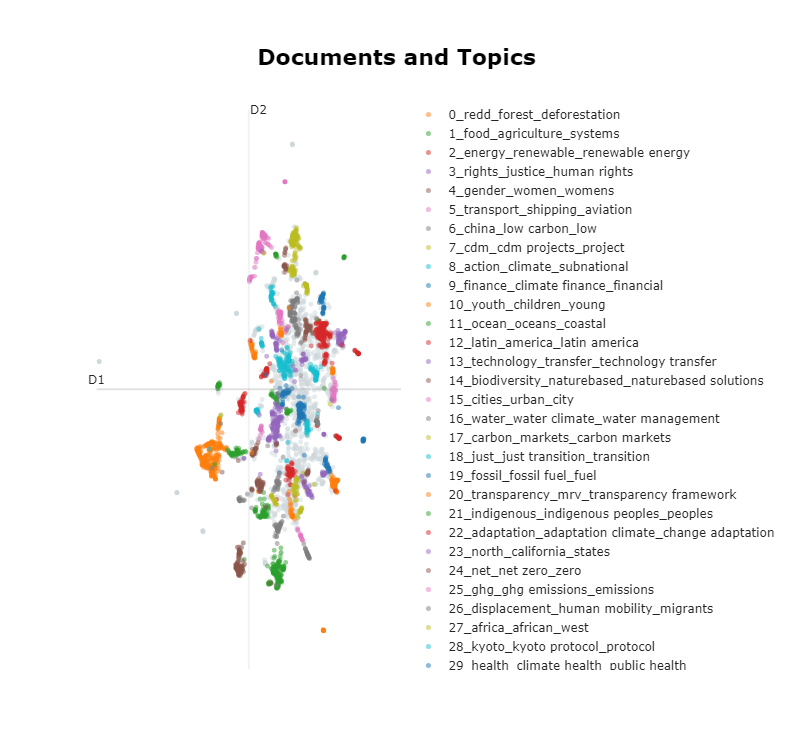

In [17]:
# Run the visualization with the original embeddings
topic_documents = topic_model.visualize_documents(docs, reduced_embeddings=plot_embeddings, 
                                hide_document_hover=True, hide_annotations=True)
topic_documents.write_html("BERT_result/"+model_type+"_documents.html")
topic_documents

### Outlier reduction
https://maartengr.github.io/BERTopic/getting_started/outlier_reduction/outlier_reduction.html#probabilities

In [18]:
new_topics_prob = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy="probabilities", threshold=0.1)
new_topics_dist = topic_model.reduce_outliers(docs, topics, strategy="distributions", threshold=0.1)
new_topics_ctfidf = topic_model.reduce_outliers(docs, topics, strategy="c-tf-idf", threshold=0.1)
document_info_new = document_info.copy()
document_info_new["new_topics_prob"] = new_topics_prob
document_info_new["new_topics_dist"] = new_topics_dist
document_info_new["new_topics_ctfidf"] = new_topics_ctfidf
document_info_new.to_csv("BERT_result/"+model_type+"_document_info_new.csv",index=False)
document_info_new

100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Document  Topic  \
0     cop 28: facing the challenges for developing c...      3   
1     the global stocktake: how to strengthen climat...     31   
2     change through participation: open dialogues a...     53   
3     partnerships for sustainable finance: opportun...      4   
4     proven climate solutions: following ip&lc lead...     21   
...                                                 ...    ...   
4683  russian business forum: corporations and regio...     28   
4684  standards to ensure high quality lulucf projec...      0   
4685  linking article 2 and article 6: experiments i...     -1   
4686  south-north dialogue - equity in the greenhous...     -1   
4687  dispute resolution in the climate change regim...     -1   

                                                   Name  \
0                   3_rights_justice_human rights_human   
1         31_equity_stocktake_global stocktake_ambition   
2                       53_citizens_public_arts_citizen   
3                        4_gender_women_womens_equality   
4     21_indigenous_indigenous peoples_peoples_peopl...   
...                                                 ...   
4683         28_kyoto_kyoto protocol_protocol_postkyoto   
4684             0_redd_forest_deforestation_indigenous   
4685        -1_climate_adaptation_change_climate change   
4686        -1_climate_adaptation_change_climate change   
4687        -1_climate_adaptation_change_climate change   

                                         Representation  \
0     [rights, justice, human rights, human, law, cl...   
1     [equity, stocktake, global stocktake, ambition...   
2     [citizens, public, arts, citizen, participatio...   
3     [gender, women, womens, equality, gender equal...   
4     [indigenous, indigenous peoples, peoples, peop...   
...                                                 ...   
4683  [kyoto, kyoto protocol, protocol, postkyoto, r...   
4684  [redd, forest, deforestation, indigenous, fore...   
4685  [climate, adaptation, change, climate change, ...   
4686  [climate, adaptation, change, climate change, ...   
4687  [climate, adaptation, change, climate change, ...   

                                    Representative_Docs  \
0     [building capacity for integrating human right...   
1     [building an inclusive global stocktake: expan...   
2     [building capacity for effective public engage...   
3     [women for climate justice leading solutions o...   
4     [making the green climate fund relevant and re...   
...                                                 ...   
4683  [implementation of the kyoto protocol in russi...   
4684  [developing redd+ safeguard systems: lessons f...   
4685  [policy,reg.and climate finance devt scenarios...   
4686  [policy,reg.and climate finance devt scenarios...   
4687  [policy,reg.and climate finance devt scenarios...   

                                            Top_n_words  Probability  \
0     rights - justice - human rights - human - law ...     0.711102   
1     equity - stocktake - global stocktake - ambiti...     0.809234   
2     citizens - public - arts - citizen - participa...     1.000000   
3     gender - women - womens - equality - gender eq...     0.751647   
4     indigenous - indigenous peoples - peoples - pe...     1.000000   
...                                                 ...          ...   
4683  kyoto - kyoto protocol - protocol - postkyoto ...     0.994990   
4684  redd - forest - deforestation - indigenous - f...     0.796909   
4685  climate - adaptation - change - climate change...     0.000000   
4686  climate - adaptation - change - climate change...     0.000000   
4687  climate - adaptation - change - climate change...     0.000000   

      Representative_document  new_topics_prob  new_topics_dist  \
0                       False                3                3   
1                       False               31               31   
2                       False               53               

In [19]:
len(document_info_new[document_info_new["new_topics_ctfidf"]==-1])

377

2024-03-16 15:22:59,815 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


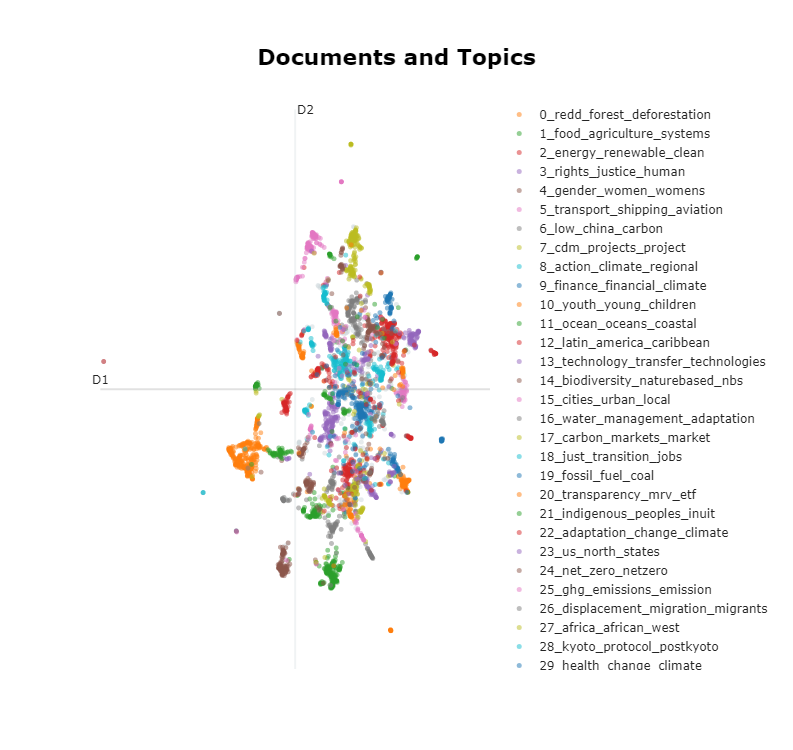

In [20]:
topic_model.update_topics(docs, topics=new_topics_ctfidf)
topic_documents_new = topic_model.visualize_documents(docs, reduced_embeddings=plot_embeddings,
                                hide_document_hover=True, hide_annotations=True)
topic_documents_new.write_html("BERT_result/"+model_type+"_documents_new.html")
topic_documents_new

20it [00:03,  5.58it/s]


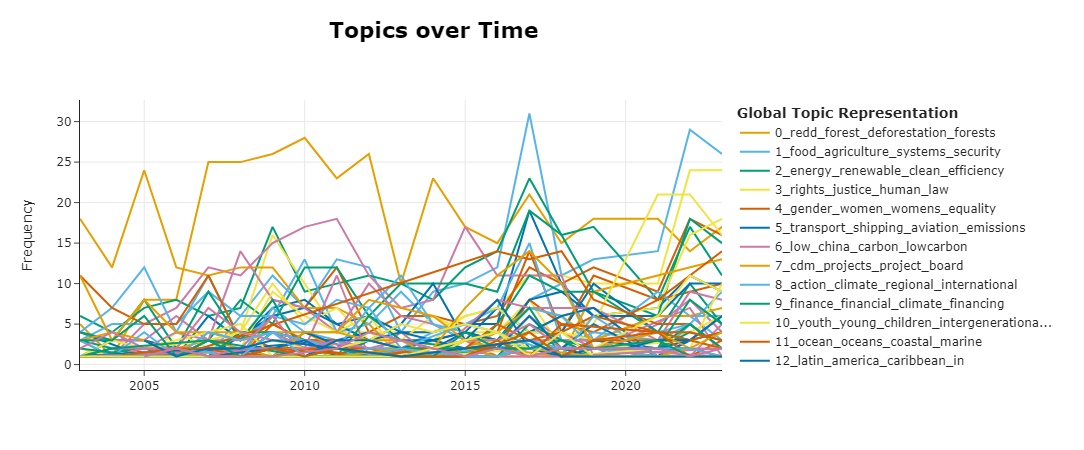

In [21]:
# plot topic result over time
topics_over_time = topic_model.topics_over_time(docs, timestamp)
topics_over_time_fig = topic_model.visualize_topics_over_time(topics_over_time)
topics_over_time_fig.write_html("BERT_result/"+model_type+"_over_time_new.html")
topics_over_time_fig

In [25]:
# export topic result over time
df['Topic'] = new_topics_ctfidf
topic_counts_per_year = df.groupby(['Year', 'Topic']).size().unstack(fill_value=0)
topic_counts_per_year.to_csv("BERT_result/"+model_type+"_topics_per_year_new.csv")

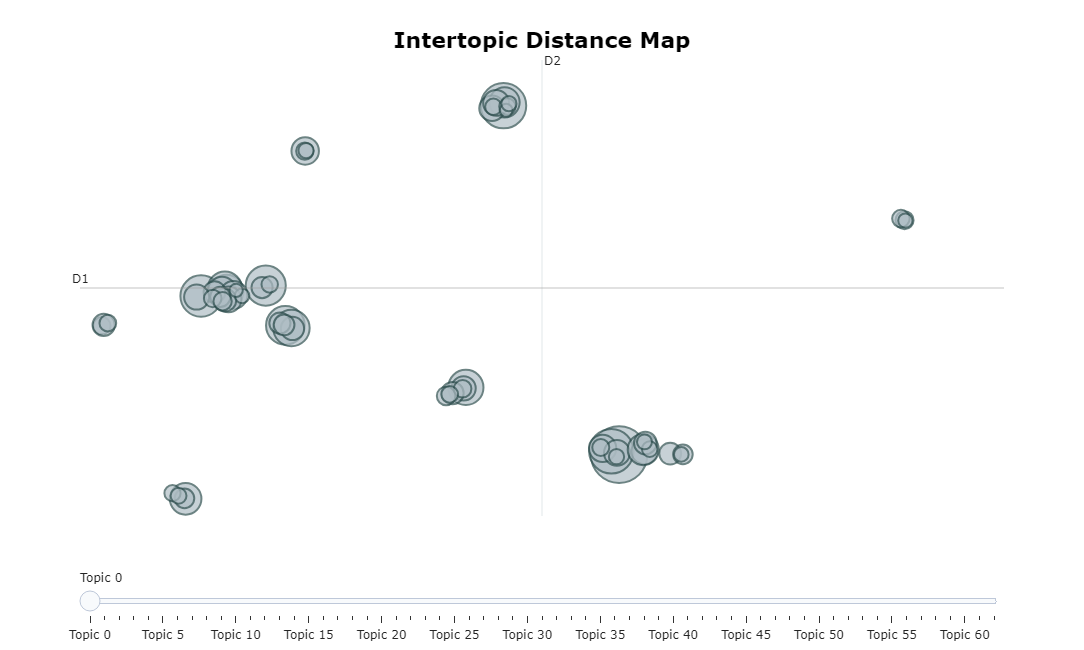

In [23]:
# plot intertopic distance  
intertopic_distance = topic_model.visualize_topics()
intertopic_distance.write_html("BERT_result/"+model_type+"_intertopic_new.html")
intertopic_distance